# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Primer-on-Orthogonal-Distance-Regression" data-toc-modified-id="Primer-on-Orthogonal-Distance-Regression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Primer on Orthogonal Distance Regression</a></div><div class="lev1 toc-item"><a href="#Generating-synthetic-data" data-toc-modified-id="Generating-synthetic-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generating synthetic data</a></div><div class="lev1 toc-item"><a href="#Fit-a-line-of-best-fit-using-least-squares-(not-ODR)" data-toc-modified-id="Fit-a-line-of-best-fit-using-least-squares-(not-ODR)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit a line of best fit using least squares (not ODR)</a></div><div class="lev1 toc-item"><a href="#Line-of-best-fit-using-ODR" data-toc-modified-id="Line-of-best-fit-using-ODR-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Line of best fit using ODR</a></div>

# Primer on Orthogonal Distance Regression

First, we will import all the libraries we will need. 

`numpy` for useful numerical computations

`scipy` for useful scientific packages

`scipy.odr` contains the Orthogonal Distance Regression (odr) function we will use

`matplotlib` and `seaborn` contain graphing functions

Then we will set up our plotting parameters, to make sure aesthetics are pleasing.

In [1]:
import numpy as np
import scipy as scipy
import scipy.odr as odr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# set to use tex, but make sure it is sans-serif fonts only
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# Generating synthetic data

Let's go ahead and simulate 15 coordinate points. Each point will have an associated measurement error, but the measurement error is not the same for all points. In particular, we simulate the error for each x- or y-coordinate as being drawn from a normal distribution centered at 0 with a standard deviation of 2.5:

In [2]:
n = 15
x = np.linspace(0, 10, n)
xerr = np.abs(np.random.normal(0, 2.5, n))
x = np.random.normal(x, xerr, n)

y = np.linspace(0, 20, n)
yerr = np.abs(np.random.normal(0, 2.5, n))
y = np.random.normal(y, yerr)

# Fit a line of best fit using least squares (not ODR)

Next, we can fit a line of best fit using the least squares algorithm. To do this, we define our function, 

$$
f(x) = a + b\cdot x,
$$

where $a, b$ are parameters to be determined by fitting. We will use the least squares algorithm by calling `scipy.optimize.curve_fit` with the function to be optimized and the data to perform the fitting. What this function will try to do is find parameters $a, b$ such that

$$
\chi^2 = \sum_i(y_{Obs,i} - f(x_i))^2,
$$

is minimized. Here, $y_i$ is the y-coordinate of the $i$th observation, and $x_i$ is the x-coordinate of the $i$th observation.

Let's optimize, find $a, b$ and then plot the results!

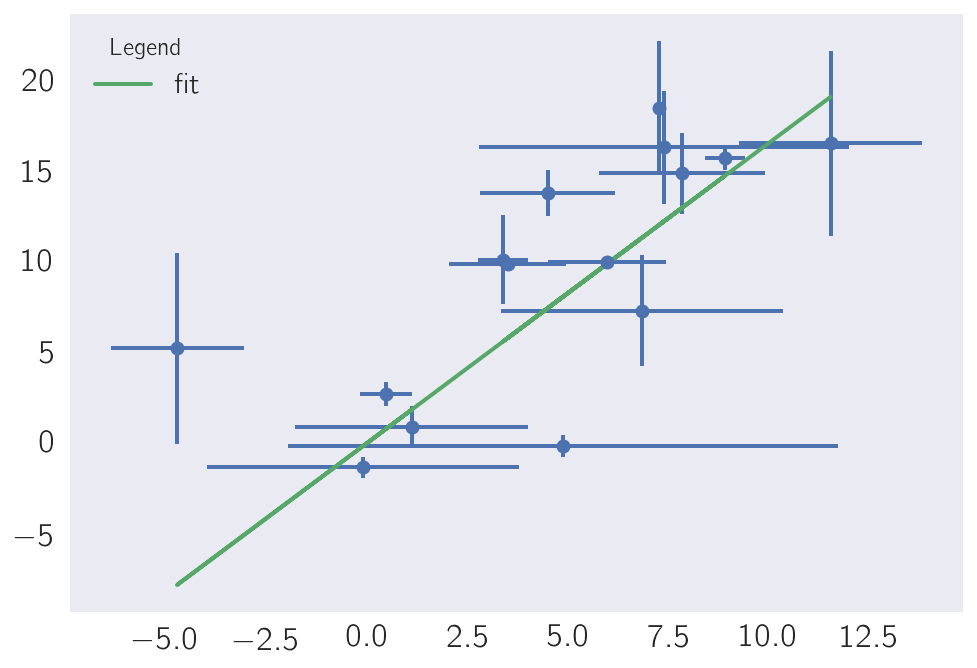

In [3]:
def line(x, a):
    """The line of best fit."""
    # unpack the parameters:
    y = a*x
    return y

popt, pcov = scipy.optimize.curve_fit(line, x, y)

# unpack the parameters of the line of best fit:
a = popt

plt.errorbar(x, y, xerr, yerr, 'o')
plt.plot(x, line(x, a), label='fit')
plt.legend(title='Legend')

# Line of best fit using ODR

We can repeat the above procedure. Again, we define the function to be minimized, but now we also define a procedure to perform the odr.

We perform the ODR as follows:

Procedure for `perform_odr(data_x, data_y, xerr, yerr)`:
1. Define the model to be fit (in this case, find the best line) by making an `odr.Model` object
2. Make an `odr.Data` object and place the data in it
3. Calculate the regression by calling `odr.ODR` with the `Data` Object, the `Model` Object and an initial parameter guess

In [4]:
def odr_line(p, x):
    """The line of best fit."""
    # unpack the parameters:
    y = p*x
    return y

def perform_odr(x, y, xerr, yerr):
    """Finds the ODR for data {x, y} and returns the result"""
    linear = odr.Model(odr_line)
    mydata = odr.Data(x, y, wd=1./xerr, we=1./yerr)
    myodr = odr.ODR(mydata, linear, beta0=[0])
    output = myodr.run()
    return output

Let's do it!

In [5]:
regression = perform_odr(x, y, xerr, yerr)

Our results are now stored in an `odr` object. We can extract the parameters by typing `odr.beta[0]` (first parameter, intercept) or `odr.beta[1]` for the slope.


The true model is           y = 2.00x
Least squares returns       y = 1.7x
ODR returns                 y = 2x



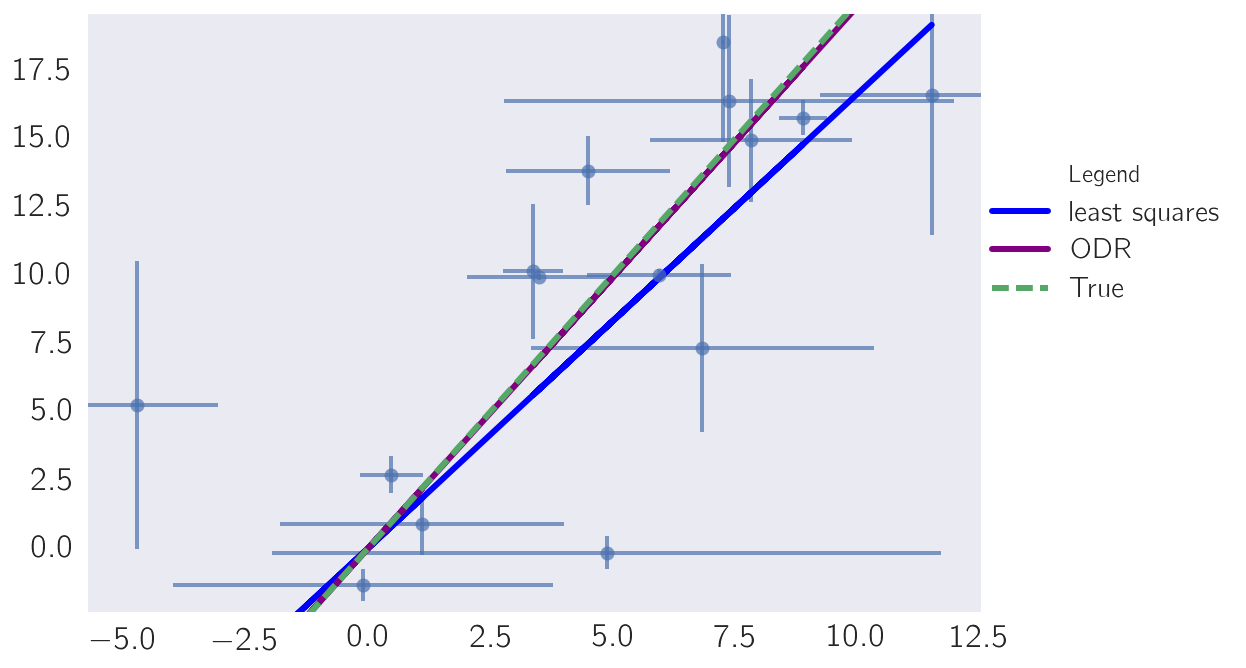

In [6]:
plt.errorbar(x, y, xerr, yerr, 'o', alpha=0.7)
plt.plot(x, line(x, a), label='least squares', lw=3, color='blue')
plt.plot(x, line(x, regression.beta[0]), label='ODR', lw=3, color='purple')

# plot the true line:
X = np.linspace(-10, 10, 10)
plt.plot(X, 2*X, label='True', lw=3, ls='--')
plt.legend(title='Legend', loc=(1, .5))
plt.xlim(np.min(x)-1, np.max(x)+1)
plt.ylim(np.min(y)-1, np.max(y)+1)
print(
"""
The true model is           y = 2.00x
Least squares returns       y = {0:.2g}x
ODR returns                 y = {1:.2g}x
""".format(a[0], regression.beta[0]))

As errors get larger, ODR will outperform least squares.